# Simulating Hess Diagrams with StarFISH

In [1]:
%matplotlib inline
import os
import numpy as np
os.getenv("STARFISH")

'/Users/jsick/code/_starfish/starfish'

## Download isochrones

The [Padova package](http://github.com/jonathansick/padova) lets us quickly download a set of the Padova group's isochrones from the CMD website. Here we'll download a grid of isochrones to cover a set of WFC3 bands. (*Note: PHAT uses ACS for the optical bands*). Padova is able to export these isochrones into a format that StarFISH understands.

In [2]:
isoc_dirname = "padova_isoc"
full_isoc_dirname = os.path.join(os.getenv("STARFISH"),
                                 isoc_dirname)

wfc3_bands = ['F275W1', 'F336W', 'F475W', 'F814W', 'F110W', 'F160W']
# z_grid = [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
#           0.001, 0.0012, 0.0016, 0.002, 0.0025, 0.0031, 0.0039, 0.0049, 0.0061, 0.0077, 0.0096,
#           0.012, 0.015, 0.019, 0.024, 0.03]
z_grid = [0.015]

In [3]:
import time
from padova import AgeGridRequest
for z in z_grid:
    r = AgeGridRequest(z, min_log_age=6.6, max_log_age=10.13, delta_log_age=0.05,
                       phot='wfc3', photsys_version='odfnew')
    for isoc in r.isochrone_set:
        isoc.export_for_starfish(full_isoc_dirname, bands=wfc3_bands)
    # time.sleep(10)

Reading from cache


In [4]:
from astropy.coordinates import Distance
import astropy.units as u

from starfisher import LibraryBuilder

input_dir = "wfc3_test"
lib_dir = "padova_lib"
d = Distance(785 * u.kpc)
builder = LibraryBuilder(input_dir, isoc_dirname, lib_dir,
                         nmag=len(wfc3_bands),
                         dmod=d.distmod.value,
                         iverb=3)
builder.install()

./mklib < wfc3_test/lib.dat


## Generating a synthetic Hess CMD library

In [5]:
from starfisher import Lockfile, Synth, ExtinctionDistribution, MockNullCrowdingTable, ColorPlane

synth_dir = "wfc3_test/synth"
crowd_path = "wfc3_test/crowding.dat"

# Setup an isochrone locking scheme for 10 age bins
# Only use one metallicity
lockfile = Lockfile(builder, synth_dir)
lockfile.lock_grid(np.linspace(6., 10.5, num=11),
                   z_groups=[('0150',)])

# No extinction
young_av = ExtinctionDistribution()
old_av = ExtinctionDistribution()
rel_extinction = np.ones(len(wfc3_bands), dtype=float)
for av in (young_av, old_av):
    av.set_uniform(0.)

# No photometric errors
crowd = MockNullCrowdingTable(crowd_path, len(wfc3_bands))

# Define colour planes to synthesize
opt_cmd = ColorPlane((wfc3_bands.index('F475W'), wfc3_bands.index('F814W')),
                     wfc3_bands.index('F814W'),
                     (-1., 3.),
                     (16., 30.),
                     35.,
                     suffix='f475f814',
                     x_label='F475W-F814W',
                     y_label='F814W')

synth = Synth(input_dir, builder, lockfile, crowd,
              rel_extinction, young_extinction=young_av, old_extinction=old_av,
              planes=[opt_cmd])
synth.run_synth(include_unlocked=False)
synth.plot_all_hess('synth_hess')

./synth < wfc3_test/synth.dat


/Users/jsick/code/_starfish/starfisher/starfisher/plots.py:32: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(hess), **_imshow)


/Users/jsick/code/_starfish/starfisher/starfisher/lockfile.py:456: RuntimeWarning: invalid value encountered in log10
  poly[:, 1] = np.log10(poly[:, 1] / 0.019)


array([  6.6 ,   6.65,   6.7 ,   6.75,   6.8 ,   6.85,   6.9 ,   6.95,
         7.  ,   7.05,   7.1 ,   7.15,   7.2 ,   7.25,   7.3 ,   7.35,
         7.4 ,   7.45,   7.5 ,   7.55,   7.6 ,   7.65,   7.7 ,   7.75,
         7.8 ,   7.85,   7.9 ,   7.95,   8.  ,   8.05,   8.1 ,   8.15,
         8.2 ,   8.25,   8.3 ,   8.35,   8.4 ,   8.45,   8.5 ,   8.55,
         8.6 ,   8.65,   8.7 ,   8.75,   8.8 ,   8.85,   8.9 ,   8.95,
         9.  ,   9.05,   9.1 ,   9.15,   9.2 ,   9.25,   9.3 ,   9.35,
         9.4 ,   9.45,   9.5 ,   9.55,   9.6 ,   9.65,   9.7 ,   9.75,
         9.8 ,   9.85,   9.9 ,   9.95,  10.  ,  10.05,  10.1 ])

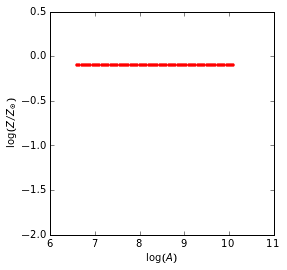

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl

from starfisher.plots import plot_isochrone_logage_logzsol, plot_lock_polygons

fig = plt.figure(figsize=(4, 4), dpi=300)
gs = mpl.gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])

plot_isochrone_logage_logzsol(ax, builder)
plot_lock_polygons(ax, lockfile)

ax.set_xlim(6., 11)
ax.set_ylim(-2, 0.5)
ax.set_xlabel(r"$\log(A)$")
ax.set_ylabel(r"$\log(Z/Z_\odot)$")
fig.show()

builder.isoc_logages

[0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015, 0.015]
